In [1]:
%matplotlib inline
%run notebook_setup

/Users/ianczekala/Documents/RML/MPoL/docs/large-tutorials/notebook_setup.py:7: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('config InlineBackend.figure_format = "retina"')


# HD143006 Tutorial Part 2

This tutorial is part 2 of the HD 143006 tutorial series (part 1 can be found [here](HD143006_part_1.md)).

We'll be covering much of the same content in the tutorials on [optimization](../ci-tutorials/optimization.md), [initalizing with the dirty image](../ci-tutorials/initializedirtyimage.md), and [cross validation](../ci-tutorials/crossvalidation.md) as part of an integrated workflow using real data. For more information on a particular step, we recommend referencing the individual tutorials.

This tutorial will cover model initialization, optimization, and cross validation, as well as touch on how to use [TensorBoard](https://www.tensorflow.org/tensorboard) to analyze the results.


## Loading Data
Let's load the data as we did in the previous HD143006 tutorial ([part 1](HD143006_part_1.md)) and create an MPoL Gridder object.

*You can download the extracted visibilities (`HD143006_continuum.npz`) directly to your working directory, or use the Astropy `download_file` utility to download it during run time.*

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.utils.data import download_file
import torch
from torch.utils import tensorboard

# downloading extracted visibilities file
fname = download_file(
    "https://zenodo.org/record/4904794/files/HD143006_continuum.npz",
    cache=True,
    pkgname="mpol",
)

# load extracted visibilities from npz file
d = np.load(fname)
uu = d["uu"]
vv = d["vv"]
weight = d["weight"]
data = d["data"]

In [3]:
from mpol import gridding, coordinates

# we'll assume the same cell_size as before
cell_size = 0.003  # arcseconds

# create DirtyImager object
coords = coordinates.GridCoords(cell_size=cell_size, npix=512)
imager = gridding.DirtyImager(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data.real,
    data_im=data.imag,
)

## Getting the Dirty Image and Creating the Model

First, we will use {class}`~mpol.gridding.DirtyImager` to solve for a dirty image, so that we can

1. confirm that we've loaded the visibilities correctly and that the dirty image looks roughly as we'd expect (as in [part 1](HD143006_part_1.ipynb))
2. use the dirty image to initialize the RML model image state (as in the [initalizing with the dirty image](../ci-tutorials/initializedirtyimage.ipynb) tutorial)

We will use Briggs weighting with `robust=0.0`, since this similar to what the DSHARP team used.

In [4]:
img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0, unit="Jy/arcsec^2")

Now is also a good time to average the visibilities and export them to a PyTorch dataset, to be used later during the RML imaging loop. To do this, we'll use the {class}`~mpol.gridding.DataAverager`.

In [5]:
averager = gridding.DataAverager(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data.real,
    data_im=data.imag,
)
dataset = (
    averager.to_pytorch_dataset()
) 

Now let's import a {class}`mpol.precomposed.SimpleNet` model for RML imaging.

In [6]:
from mpol.precomposed import SimpleNet

model = SimpleNet(coords=coords, nchan=averager.nchan)

## Initializing Model with the Dirty Image

Before we begin the optimization process, we need to choose a set of starting values for our image model. So long as we run the optimization process to convergence, this starting point could be anything. But, it's also true that "better" guesses will lead us to convergence faster. A fairly decent starting guess is the dirty image itself, since it is already a maximum likelihood fit to the data. The problem, though, is that the dirty image contains pixels with negative flux, while by construction our {class}`mpol.precomposed.SimpleNet` model enforces image positivity. One solution is to train the RML model such that the mean squared error between its image plane component and the dirty image are minimized. This "mini" optimization loop is just to find a starting point for the actual RML optimization loop, which will be described later in this tutorial.

Following the [initalizing with the dirty image](../ci-tutorials/initializedirtyimage.md) tutorial, we use PyTorch's [mean squared error](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) function to calculate the loss between the RML model image and the dirty image.

In [7]:
# convert the dirty image into a tensor
dirty_image = torch.tensor(img.copy())

# initialize an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)
loss_fn = torch.nn.MSELoss()  # creating the MSEloss function from Pytorch

In [8]:
for iteration in range(500):

    optimizer.zero_grad()

    model()  # get the predicted model
    sky_cube = model.icube.sky_cube

    loss = loss_fn(sky_cube, dirty_image)  # calculate the loss

    loss.backward()  # calculate gradients of parameters
    optimizer.step()  # update the parameters

Let's visualize the actual dirty image and our "pseudo-dirty image" that results from the optimization process.

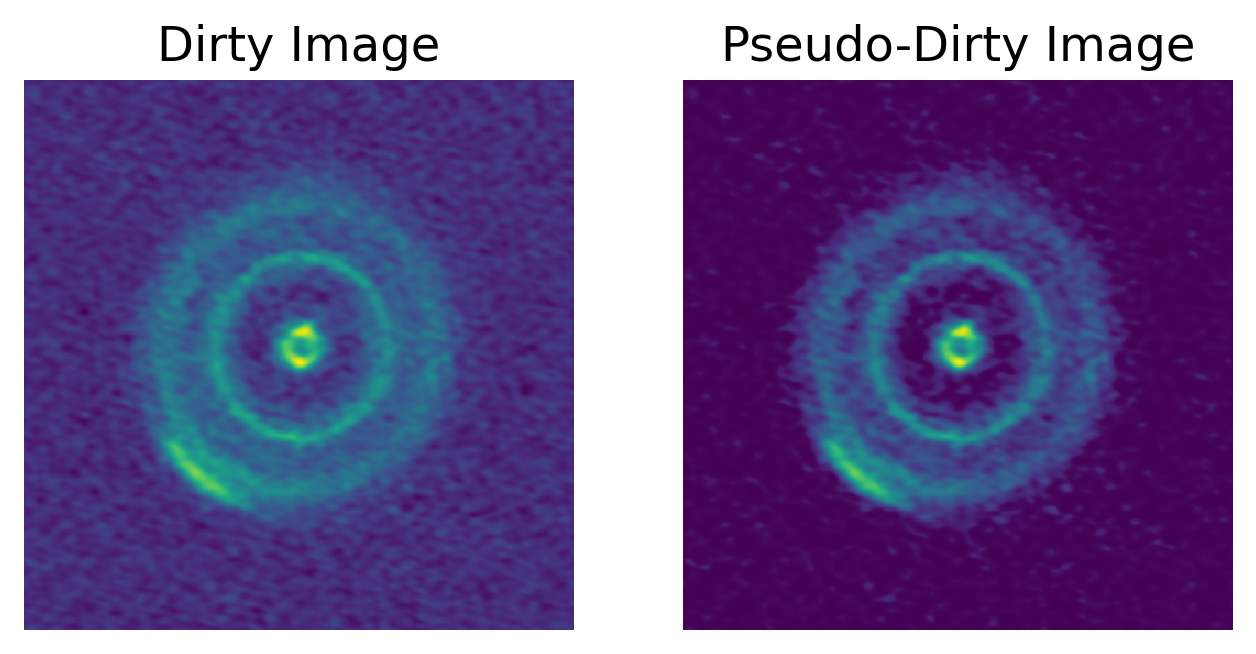

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(6.5, 4))

ax[0].imshow(
    np.squeeze(dirty_image.detach().cpu().numpy()),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)

ax[1].imshow(
    np.squeeze(model.icube.sky_cube.detach().cpu().numpy()),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)

r = 0.75
for a in ax:
    a.set_xlim(left=0.75, right=-0.75)
    a.set_ylim(bottom=-0.75, top=0.75)
    a.axis("off")

ax[0].set_title("Dirty Image")
_ = ax[1].set_title("Pseudo-Dirty Image")

We can confirm that the pseudo-dirty image contains no negative flux values

In [10]:
print(
    "Minimum flux value {:.4f} Jy/arcsec^2".format(
        np.min(model.icube.sky_cube.detach().cpu().numpy())
    )
)

Minimum flux value 0.0014 Jy/arcsec^2


Later in this tutorial, we'll want to run many RML optimization loops with different hyperparameter configurations. To make this process easier, we'll save the model state to disk, making it easy for us restart from the pseudo-dirty image each time. More information on saving and loading models (and the `state_dict`) can be found in the [PyTorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

In [11]:
torch.save(model.state_dict(), "model.pt")

## Visualization utilities

In this section we'll set up some visualization tools, including [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html).

Note that to display the TensorBoard dashboards referenced in this tutorial, you will need to run a TensorBoard instance on your own device. The code necessary to do this is displayed in this tutorial as ``#%tensorboard --logdir <directory>``. Uncomment and execute this IPython line magic command in Jupyter Notebook to open the dashboard.

In [12]:
from torch.utils.tensorboard import SummaryWriter
import os

logs_base_dir = "./logs/"
writer = SummaryWriter(logs_base_dir)
os.makedirs(logs_base_dir, exist_ok=True)
%load_ext tensorboard

Here we'll define a plotting routine that will visualize the image plane model cube.

In [13]:
def log_figure(model):
    """
    Args:
        model: the SimpleNet model instance

    Returns:
        matplotlib figure with plots corresponding to image
        plane model cube.
    """

    fig, ax = plt.subplots(ncols=1, nrows=1)
    im = ax.imshow(
        np.squeeze(model.icube.sky_cube.detach().cpu().numpy()),
        origin="lower",
        interpolation="none",
        extent=model.icube.coords.img_ext,
    )
    plt.colorbar(im, ax=ax)

    return fig

## Training loop

Now lets encapsulate the training loop into a function which we can easily re-run with different configuration values.

To learn more information about the components of this training loop, please see the {mod}`Losses API <mpol.losses>`.

In [14]:
from mpol import losses


def train(model, dataset, optimizer, config, writer=None, logevery=50):
    model.train()
    for iteration in range(config["epochs"]):
        optimizer.zero_grad()
        vis = model()  # calculate the predicted model
        sky_cube = model.icube.sky_cube

        loss = (
            losses.nll_gridded(vis, dataset)
            + config["lambda_sparsity"] * losses.sparsity(sky_cube)
            + config["lambda_TV"] * losses.TV_image(sky_cube)
            + config["entropy"] * losses.entropy(sky_cube, config["prior_intensity"])
            + config["TSV"] * losses.TSV(sky_cube)
        )

        if (
            iteration % logevery == 0
        ) and writer is not None:  # logging the loss and image for visualization and analysis
            writer.add_scalar("loss", loss.item(), iteration)
            writer.add_figure("image", log_figure(model), iteration)

        loss.backward()  # calculate gradient of the parameters
        optimizer.step()  # update the model parameters

    return loss.item()

Now lets initialize the model to the pseudo-dirty image, set our hyperparameters in a `config` dictionary, and create our optimizer.

The hyperparameters (also referred to as scalar prefactors in the {ref}`rml-intro-label`. Most of these hyperparameters, such as `lambda_TV` and `entropy` are used in the loss functions and can be read about {mod}`here <mpol.losses>`. We chose these specific values from a past hyperparameter tuning trial, since they result in a decent image but still have a suboptimal cross-validation score, leaving something for us to do in the cross-validation loops at the end of this tutorial.

Hyperparameter values are not a "one size fits all" metric, so if you are working with a different dataset you will most likely find successful images with a different set of hyperparameters. To find your own hyperparameters, we recommend looking into [Ray Tune](https://docs.ray.io/en/master/tune/index.html), [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html), or your favorite hyperparameter tuning library.

In [15]:
model.load_state_dict(
    torch.load("model.pt")
)  # load our initialized model from the previous section

<All keys matched successfully>

In [16]:
config = (
    {  # config includes the hyperparameters used in the function and in the optimizer
        "lr": 0.3,
        "lambda_sparsity": 7.0e-05,
        "lambda_TV": 0.00,
        "entropy": 1e-03,
        "prior_intensity": 1.5e-07,
        "TSV": 0.00,
        "epochs": 1000,
    }
)

In [17]:
optimizer = torch.optim.Adam(
    model.parameters(), lr=config["lr"]
)  # create our optimizer, using the learning rate from config

We are now ready to run the training loop.

In [18]:
train(model, dataset, optimizer, config, writer=writer)

1.4976273207908612

Below we can see the loss function, images, and residuals for every saved iteration including our final result. To view the loss function, navigate to the scalars tab. To view the images, be sure your window is wide enough to navigate to the images tab within TensorBoard. The images, in order from left-right top-bottom are: image cube representation, imaged residuals, visibility amplitudes of model on a log scale, residual amplitudes on a log scale. You can use the slider to view different iterations.

In [19]:
# %tensorboard --logdir {logs_base_dir}
## uncomment the above line when running to view TensorBoard

## Cross Validation

Now we will move onto cross validation, which is a technique used to assess model validity. The general idea is that we store some fraction of the dataset as a test dataset and using the remaining data to train the model. Once the model is trained, it is used to predict the missing values of the data in the test dataset. These predicted values are compared to the values from the test dataset, producing a cross validation score.

The advantage of $k$-fold cross validation is that it allows one dataset to be used to train the model multiple times since it can take different chunks out for the test dataset. For more information see the [Cross Validation tutorial](../ci-tutorials/crossvalidation.ipynb).

Just like in the previous section we will be viewing our results in TensorBoard, with the addition of the cross validation score log.

Cross validation requires a `test` function (to determine the cross validation score) and a `cross_validate` function (to utilize cross validation with the previous `train` function). We implement these below.

In [20]:
def test(model, dataset):
    model.eval()
    vis = model()
    loss = losses.nll_gridded(
        vis, dataset
    )  # calculates the loss function that goes to make up the cross validation score
    return loss.item()

In [21]:
def cross_validate(model, config, k_fold_datasets, MODEL_PATH, writer=None):
    test_scores = []

    for k_fold, (train_dset, test_dset) in enumerate(k_fold_datasets):

        # reset model
        model.load_state_dict(torch.load(MODEL_PATH))

        # create a new optimizer for this k_fold
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

        # train for a while
        train(model, train_dset, optimizer, config, writer=writer)
        # evaluate the test metric
        test_scores.append(test(model, test_dset))

    # aggregate all test scores and sum to evaluate cross val metric
    test_score = np.sum(np.array(test_scores))

    # adds cross validation score
    if writer is not None:
        writer.add_scalar("Cross Validation", test_score)

    return test_score

Now that we have our functions defined, we need to divide our dataset into training and test datasets. There are many ways of going about this; here we are splitting the dataset into radial and azimuthal chunks in a dartboard-like pattern. MPoL's `Dartboard` presents an easy built-in way to get the polar coordinate grid of a dataset. To to read more, please see [Choosing the K-folds](../ci-tutorials/crossvalidation.md#choosing-the-k-folds) in the [Cross Validation tutorial](../ci-tutorials/crossvalidation.md).

In [ ]:
from mpol import crossval, datasets

# create a radial and azimuthal partition for the dataset
dartboard = datasets.Dartboard(coords=coords)

# create cross validator using this "dartboard"
k = 5
cv = crossval.DartboardSplitGridded(dataset, k, dartboard=dartboard, seed=42)

# ``cv`` is a Python iterator, it will return a ``(train, test)`` pair of ``GriddedDataset``s for each iteration.
# Because we'll want to revisit the individual datasets
# several times in this tutorial, we're storing them into a list

k_fold_datasets = [(train, test) for (train, test) in cv]

`MODEL_PATH` is defined below so we can reset the model between cross validation loops by reloading the `model.pt` we saved, which contained the state of the model initialized to the pseudo-dirty image. We will run the cross validation loops for a few different configurations, starting with the hyperparameters found in `config`, defined above in this tutorial. This configuration has been included in the following cell for convenience.

In [23]:
MODEL_PATH = "model.pt"

new_config = (
    {  # config includes the hyperparameters used in the function and in the optimizer
        "lr": 0.3,
        "lambda_sparsity": 7.0e-05,
        "lambda_TV": 0.00,
        "entropy": 1e-03,
        "prior_intensity": 1.5e-07,
        "TSV": 0.00,
        "epochs": 1000,
    }
)

We are now ready to run our cross validation loop. We'll run this a few times while changing hyperparameters in the config to lower the cross validation score then compare all three with TensorBoard.

In [24]:
# new directory to write the progress of our first cross val. loop to
cv_log_dir1 = logs_base_dir + "cv/cv1/"
cv_writer1 = SummaryWriter(cv_log_dir1)
os.makedirs(cv_log_dir1, exist_ok=True)

cv_score1 = cross_validate(
    model, new_config, k_fold_datasets, MODEL_PATH, writer=cv_writer1
)
print(f"Cross Validation Score: {cv_score1}")

Cross Validation Score: 146.87611987368703


In [25]:
# new directory to write the progress of our second cross val. loop to
cv_log_dir2 = logs_base_dir + "cv/cv2/"
cv_writer2 = SummaryWriter(cv_log_dir2)
os.makedirs(cv_log_dir2, exist_ok=True)

new_config = (
    {  # config includes the hyperparameters used in the function and in the optimizer
        "lr": 0.3,
        "lambda_sparsity": 1.0e-4,
        "lambda_TV": 1.0e-4,
        "entropy": 1e-02,
        "prior_intensity": 2.0e-09,
        "TSV": 1.0e-6,
        "epochs": 850,
    }
)
cv_score2 = cross_validate(
    model, new_config, k_fold_datasets, MODEL_PATH, writer=cv_writer2
)
print(f"Cross Validation Score: {cv_score2}")

Cross Validation Score: 73.9870907309473


In [26]:
# new directory to write the progress of our third cross val. loop to
cv_log_dir3 = logs_base_dir + "cv/cv3/"
cv_writer3 = SummaryWriter(cv_log_dir3)
os.makedirs(cv_log_dir3, exist_ok=True)

new_config = (
    {  # config includes the hyperparameters used in the function and in the optimizer
        "lr": 0.3,
        'lambda_sparsity': 1.8e-4,
        'lambda_TV': 2.3e-5,
        'entropy': 7.4e-06,
        'prior_intensity': 5.0e-07,
        'TSV': 1.0e-02,
        "epochs": 1000,
    }
)

cv_score3 = cross_validate(
    model, new_config, k_fold_datasets, MODEL_PATH, writer=cv_writer3
)
print(f"Cross Validation Score: {cv_score3}")

Cross Validation Score: 68.29980320679063


Here is the final result for our model with the lowest cross validation score:

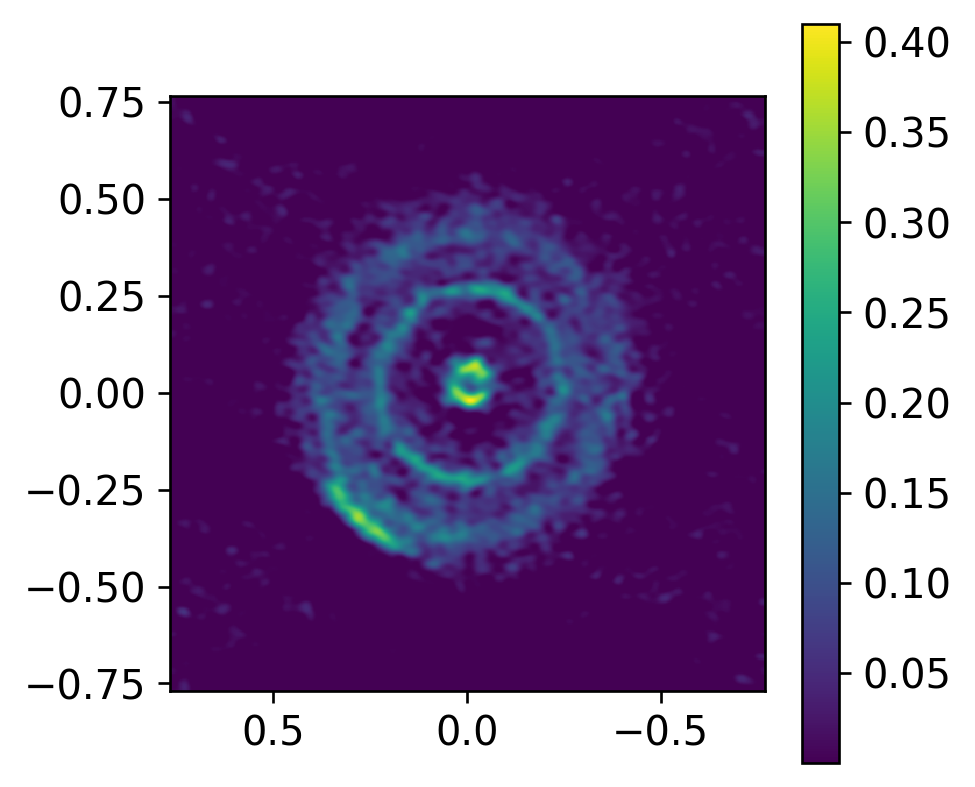

In [27]:
fig, ax = plt.subplots()
im = ax.imshow(
    np.squeeze(model.icube.sky_cube.detach().cpu().numpy()),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)
plt.colorbar(im)

And you can visualize all of the results in TensorBoard.

It may seem strange that the lowest total converged loss values do not correspond with the lowest cross validation scores. This is just a consequence of the fact that we are working with loss functions that correspond to the *logarithm* of the likelihood function and prior functions. This means that the normalization prefactors aren't required for each optimization loop (so we don't calculate them), which also has the consequence that we can't directly compare loss values across different hyperparameter settings (this is the role of cross-validation).

In [28]:
cv_log_dir = logs_base_dir + "cv/"
# %tensorboard --logdir {cv_log_dir}
## uncomment the above line when running to view TensorBoard

Hopefully this tutorial has provided an introduction to RML imaging with an actual ALMA dataset.

We started by initializing the RML model to a pseudo-dirty image, which allowed our model converge to the optimal image in fewer iterations.

We also used cross validation to help us understand how well the model fits the dataset. Using TensorBoard, we were able to visualize how changing hyperparameters can result in a lower cross validation score, and therefore a better image, if done correctly. The process of changing the hyperparameters can be automated using a hyperparameter tuning library which we will explore in Part 3 of this tutorial series.

Of the three hyperparameter configurations that we cross-validated above, the third has the lowest cross validation score, and so we might reasonably conclude that this image most closely matches reality because it generates well to new data.

If you would like to compare these results yourself, please run TensorBoard locally. In the next part of the HD143006 tutorial we will be expanding on how to analyze the results of the training, optimization loops, hyperparameter tuning, and exploring the full pipeline of data analysis which can be adapted to any real world data.